In [1]:
from gensim import downloader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import pandas as pd
import random


from gensim.test.utils import datapath
from gensim import utils
import gensim.models
from nltk.tokenize import sent_tokenize
import nltk

In [2]:
def get_details(dataframe,wv_model):

    details_list = []
    #going through dataset and evaluating the closest synonym to the question
    for index, row in dataframe.iterrows():
        question=row['question']
        answer=row['answer']
        system_guess_word=''
        best_choice_similarity=-1
        
        if question in wv_model.key_to_index:        
            for index in range(0,4):
                choice=row[str(index)]
                if choice in wv_model.key_to_index:
                    choice_similarity=wv_model.similarity(question,choice)
                    if choice_similarity>best_choice_similarity:
                        best_choice_similarity=choice_similarity
                        system_guess_word=choice
        
        #validate label
        if best_choice_similarity==-1:
            label='guess'
            #If label is "guess" then choose the system word randomly
            random_column = str(random.randint(0,3))
            system_guess_word= row[random_column]
        elif answer==system_guess_word:
            label='correct'
        else:
            label='wrong'
        #add each row to the list
        details_list.append([question,answer,system_guess_word,label])
        #print(f"{question},{answer},{system_guess_word},{label}")
    
    return details_list

In [3]:
#generate output file with details
def generate_details_file(model_name,details_list):
    output_file_name=f"{model_name}-details.csv"
    with open(output_file_name, 'w') as output_file:
        for row in details_list:            
            for index in range(0,4):
                if(index==0):                    
                    output_file.write(row[index])  
                else:
                    output_file.write(',' + row[index])
            output_file.write('\n')

In [4]:
#append results from each model to analysis file
def append_results(model_name,vocabulary_size,details_list):
    
    output_file_name = "analysis.csv"
    #C is count_correct
    C = 0
    count_guess = 0
    
    for row in details_list:
        if row[3] == 'correct':            
            C +=1
        elif row[3] == 'guess':
            count_guess +=1
    #V  is number of questions without guess
    V = len(details_list) - count_guess
    model_accuracy = C / V

    with open(output_file_name, 'a') as output_file:
         output_file.write(f"{model_name},{vocabulary_size},{C},{V},{model_accuracy}\n")

In [5]:
def evaluate(model_name, dataframe, model):
    list_details = get_details(dataframe,model)
    generate_details_file(model_name,list_details)
    vocabulary_size = len(model.key_to_index)
    append_results(model_name,vocabulary_size,list_details)

In [6]:
# Load dataset
dataframe = pd.read_csv('synonym.csv')

In [7]:
#Task 1
#Load wv_google
model_name = 'word2vec-google-news-300'
model=downloader.load(model_name)
evaluate(model_name, dataframe, model)

In [8]:
#Task 2
# 2 new models from different corpora, but with the same embedding size 100

model_name = 'English-CoNLL17-100'
model = KeyedVectors.load_word2vec_format('./40/model.bin', binary=True)
evaluate(model_name, dataframe, model)

model_name = 'glove-wiki-gigaword-100'
model=downloader.load(model_name)
evaluate(model_name, dataframe, model)

In [9]:
# 2 models from the same corpus but different embedding sizes

model_name = 'glove-twitter-100'
model=downloader.load(model_name)
evaluate(model_name, dataframe, model)

model_name = 'glove-twitter-200'
model=downloader.load(model_name)
evaluate(model_name, dataframe, model)

In [10]:
# Preprocessing
# Open the file
books_name = ['aliseinwonderland.txt','the_hound_of_baskervilles.txt','frankenstein.txt','thegreatgatsby.txt','xmascarol.txt']
#process sentences from books
books_sentences_tokenized=[]

for book in books_name:
    with open(book,'r',encoding='utf-8') as file:
        text=file.read()

    sentences_tokenized=sent_tokenize(text)
    books_sentences_tokenized.extend(sentences_tokenized)

#process list of sentence to a list of list of words
words_list = []

for line in books_sentences_tokenized:    
    words_list.append(utils.simple_preprocess(line))

In [11]:
# Parameters
e5 = 100
e6 = 300
w1 = 5
w2 = 10

In [12]:
model_name = f'5-books-corpus-{e5}-{w1}'

model_train1 = gensim.models.Word2Vec(sentences=words_list, vector_size=e5, window=w1)
model1 = model_train1.wv
evaluate(model_name, dataframe, model1)

In [13]:
model_name = f'5-books-corpus-{e5}-{w2}'

model_train2 = gensim.models.Word2Vec(sentences=words_list, vector_size=e5, window=w2)
model2= model_train2.wv
evaluate(model_name, dataframe, model2)

In [14]:
model_name = f'5-books-corpus-{e6}-{w1}'

model_train3 = gensim.models.Word2Vec(sentences=words_list, vector_size=e6, window=w1)
model3 = model_train3.wv
evaluate(model_name, dataframe, model3)

In [15]:
model_name = f'5-books-corpus-{e6}-{w2}'
model_train4 = gensim.models.Word2Vec(sentences=words_list, vector_size=e6, window=w2)
model4 = model_train4.wv
evaluate(model_name, dataframe, model4)

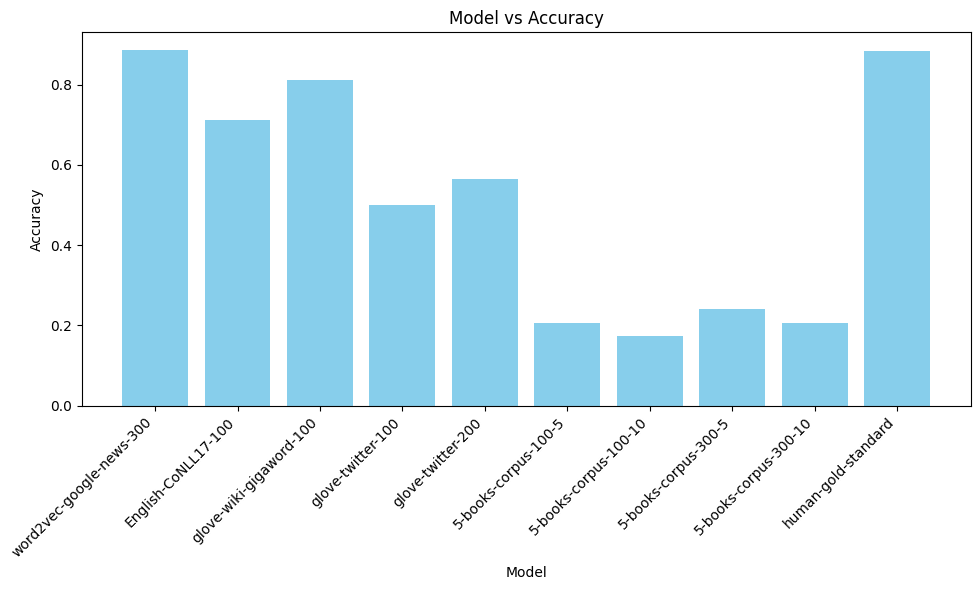

In [16]:
# Plot the model vs accuracy
# Load analysis results
analysis_dataframe = pd.read_csv('analysis.csv', header=None)
#Add collective Human Gold-Standard
gold_standard = ['human-gold-standard',0,0,0,0.885]
analysis_dataframe.loc[len(analysis_dataframe)] = gold_standard

#plot
plt.figure(figsize=(10, 6))
plt.bar(analysis_dataframe[0], analysis_dataframe[4], color='skyblue')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.title('Model vs Accuracy')
plt.tight_layout()
plt.show()